<a href="https://colab.research.google.com/github/cyuancheng/Stock_Prediction/blob/master/ETF_TimeSeries_TradingSignal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ETF trading signal testing

In [0]:
import datetime as dt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [17]:

# set start and end date
start_date = dt.datetime(2000, 1, 1)
end_date = dt.datetime.now()

# read qqq data from Yahoo api
df = web.DataReader('qqq', 'yahoo', start_date, end_date)

# save as csv
# df.to_csv('ETF_qqq.csv')

# read csv file
# df = pd.read_csv('ETF_qqq.csv', parse_dates = True, index_col=0)

df.tail(6)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-07-05,191.399994,189.389999,190.130005,191.050003,21415600.0,191.050003
2019-07-08,189.869995,188.929993,189.809998,189.710007,17598800.0,189.710007
2019-07-09,190.899994,188.649994,188.809998,190.660004,19193500.0,190.660004
2019-07-10,193.089996,191.470001,191.820007,192.559998,28374500.0,192.559998
2019-07-11,193.339996,191.809998,192.850006,192.419998,23736100.0,192.419998
2019-07-12,193.539993,192.449997,192.630005,193.529999,20195600.0,193.529999


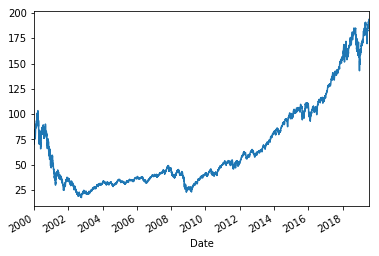

In [18]:
# show plot
df['Adj Close'].plot()
plt.show()

#### 14, 50, 200-day moving avereage

In [19]:
df['14d'] = df['Adj Close'].rolling(window=14, min_periods=0, center = False).mean()
df['50d'] = df['Adj Close'].rolling(window=50, min_periods=0, center = False).mean()
df['200d'] = df['Adj Close'].rolling(window=200, min_periods=0, center = False).mean()

df.dropna(inplace=True)
df.tail()

,High,Low,Open,Close,Volume,Adj Close,14d,50d,200d
Date,,,,,,,,,
2019-07-08,189.869995,188.929993,189.809998,189.710007,17598800.0,189.710007,188.062383,183.633683,173.825915
2019-07-09,190.899994,188.649994,188.809998,190.660004,19193500.0,190.660004,188.395329,183.642295,173.873611
2019-07-10,193.089996,191.470001,191.820007,192.559998,28374500.0,192.559998,188.814099,183.681523,173.920795
2019-07-11,193.339996,191.809998,192.850006,192.419998,23736100.0,192.419998,189.098857,183.747486,173.972285
2019-07-12,193.539993,192.449997,192.630005,193.529999,20195600.0,193.529999,189.482857,183.847822,174.026792


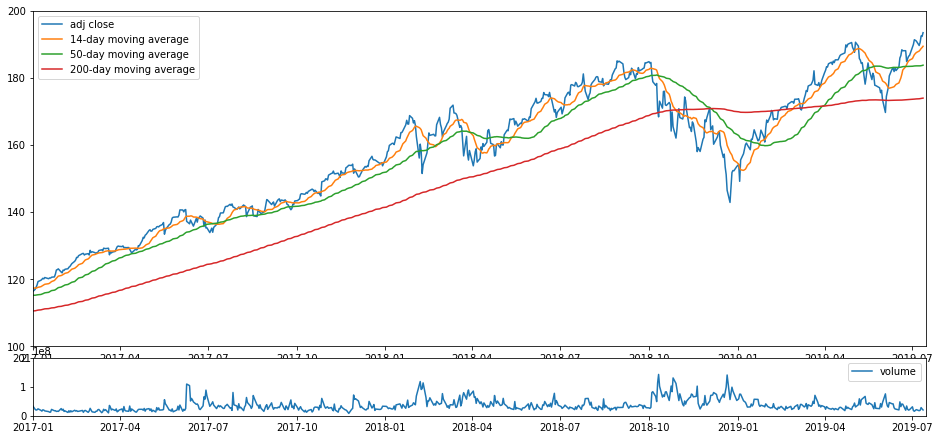

In [20]:
#plot
plt.figure(figsize=(16,10))
ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1) 
ax2 = plt.subplot2grid((8,1), (5,0), rowspan=1, colspan=1, sharex=ax1) 
ax1.plot(df.index, df['Adj Close'], label='adj close')
ax1.plot(df.index, df['14d'], label='14-day moving average')
ax1.plot(df.index, df['50d'], label='50-day moving average')
ax1.plot(df.index, df['200d'], label='200-day moving average')
ax2.plot(df.index, df['Volume'], label='volume')

# set xlim
start_date1 = dt.datetime(2017, 1, 1)
end_date = dt.datetime.now()
ax1.set_xlim([start_date1, end_date ])
ax2.set_xlim([start_date1, end_date ])
ax1.set_ylim([100, 200])
ax2.set_ylim([0, 0.2e9])

ax1.legend();ax2.legend()
plt.show()

#### Trading strategy

*Set regime:*
- if the 14 day average is above the 50 day average --> a bullish regime
- if the 14 day average is below the 50 day average --> a bearish regime


In [21]:
df['14d-50d'] = df['14d'] - df['50d']
df.tail()

,High,Low,Open,Close,Volume,Adj Close,14d,50d,200d,14d-50d
Date,,,,,,,,,,
2019-07-08,189.869995,188.929993,189.809998,189.710007,17598800.0,189.710007,188.062383,183.633683,173.825915,4.428701
2019-07-09,190.899994,188.649994,188.809998,190.660004,19193500.0,190.660004,188.395329,183.642295,173.873611,4.753034
2019-07-10,193.089996,191.470001,191.820007,192.559998,28374500.0,192.559998,188.814099,183.681523,173.920795,5.132576
2019-07-11,193.339996,191.809998,192.850006,192.419998,23736100.0,192.419998,189.098857,183.747486,173.972285,5.351372
2019-07-12,193.539993,192.449997,192.630005,193.529999,20195600.0,193.529999,189.482857,183.847822,174.026792,5.635035


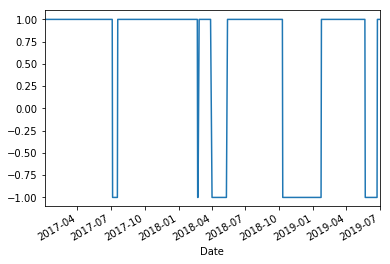

In [22]:

df["Regime"] = np.where(df['14d-50d'] > 0, 1, 0)  # bullish regime = 1
df["Regime"] = np.where(df['14d-50d'] < 0, -1, df["Regime"]) # bearish regime = -1

df.loc['2017-01-01':'2019-07-01','Regime'].plot()

In [23]:
print('Bullish regime = {}%'.format(df['Regime'][df["Regime"]==1].count()/len(df)*100))
print('Bearish regime = {}%'.format(df['Regime'][df["Regime"]==-1].count()/len(df)*100))

Bullish regime = 63.78257328990228%
Bearish regime = 35.93241042345277%


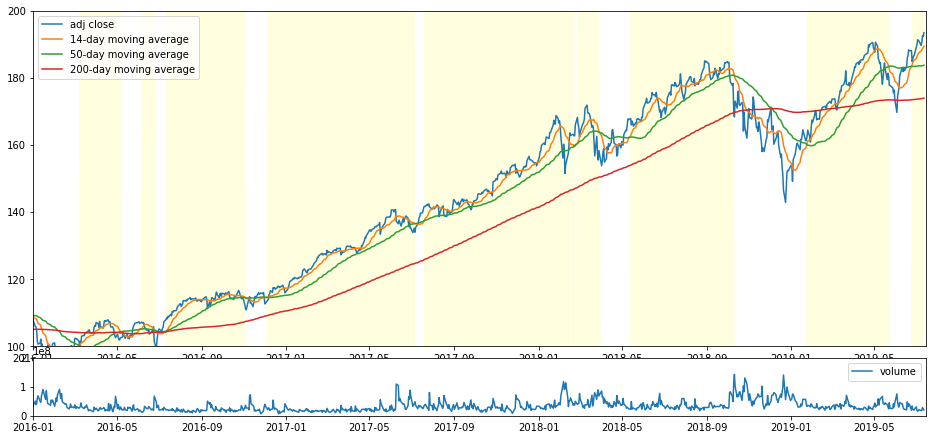

In [27]:
#plot (including bullish vs bearish regime)

plt.figure(figsize=(16,10))
ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1) 
ax2 = plt.subplot2grid((8,1), (5,0), rowspan=1, colspan=1, sharex=ax1) 
ax1.plot(df.index, df['Adj Close'], label='adj close')
ax1.plot(df.index, df['14d'], label='14-day moving average')
ax1.plot(df.index, df['50d'], label='50-day moving average')
ax1.plot(df.index, df['200d'], label='200-day moving average')

# yellow --> bullish regime
ax1.fill_between(df.index, df['Regime']*100+100, color='lightyellow')
ax2.plot(df.index, df['Volume'], label='volume')

# set xlim
start_date1 = dt.datetime(2016, 1, 1)
end_date = dt.datetime.now()
ax1.set_xlim([start_date1, end_date ])
ax2.set_xlim([start_date1, end_date ])
ax1.set_ylim([100, 200])
ax2.set_ylim([0, 0.2e9])


ax1.legend();ax2.legend()
plt.show()

The bullish regime : yellow. The bearish regime: white:
- Stock price moving from yellow to white gives a sell signal
- Stock price moving from white to yellow gives a buy signal

#### Trading signal
Cross-over between bullish and bearish

- bullish --> bearish  : sell signal
- bearish --> bullish : buy signal


In [28]:
# only show the sign of difference


df["Signal"] = np.sign(df["Regime"] - df["Regime"].shift(1))

df.tail()

,High,Low,Open,Close,Volume,Adj Close,14d,50d,200d,14d-50d,Regime,Signal
Date,,,,,,,,,,,,
2019-07-08,189.869995,188.929993,189.809998,189.710007,17598800.0,189.710007,188.062383,183.633683,173.825915,4.428701,1,0.0
2019-07-09,190.899994,188.649994,188.809998,190.660004,19193500.0,190.660004,188.395329,183.642295,173.873611,4.753034,1,0.0
2019-07-10,193.089996,191.470001,191.820007,192.559998,28374500.0,192.559998,188.814099,183.681523,173.920795,5.132576,1,0.0
2019-07-11,193.339996,191.809998,192.850006,192.419998,23736100.0,192.419998,189.098857,183.747486,173.972285,5.351372,1,0.0
2019-07-12,193.539993,192.449997,192.630005,193.529999,20195600.0,193.529999,189.482857,183.847822,174.026792,5.635035,1,0.0


signal: buy=1, sell= -1, hold =0.

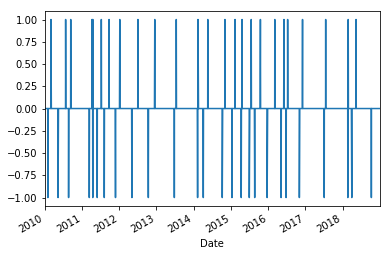

In [29]:
df.loc['2010-01-01':'2018-12-31','Signal'].plot()

In [30]:
#when to sell
df[df['Signal']==1].index

DatetimeIndex(['2000-01-26', '2000-06-15', '2000-08-28', '2001-01-30',
               '2001-05-01', '2001-10-26', '2002-03-21', '2002-08-28',
               '2002-10-25', '2003-01-17', '2003-03-19', '2003-08-21',
               '2004-04-13', '2004-06-08', '2004-09-13', '2005-05-19',
               '2005-11-04', '2006-03-30', '2006-08-22', '2007-02-09',
               '2007-02-14', '2007-04-04', '2007-09-12', '2008-04-03',
               '2008-08-15', '2009-01-05', '2009-02-06', '2009-03-26',
               '2010-03-05', '2010-07-27', '2010-09-15', '2011-04-12',
               '2011-04-20', '2011-07-12', '2011-09-26', '2012-01-09',
               '2012-07-05', '2012-12-17', '2013-07-16', '2014-02-14',
               '2014-05-21', '2014-11-05', '2015-02-12', '2015-04-22',
               '2015-07-21', '2015-10-19', '2016-03-08', '2016-06-06',
               '2016-07-12', '2016-12-05', '2017-07-20', '2018-02-26',
               '2018-05-14', '2019-01-24', '2019-06-25'],
              dtype

In [31]:
#when to buy
df[df['Signal']==-1].index

DatetimeIndex(['2000-01-24', '2000-04-13', '2000-08-07', '2000-09-21',
               '2001-02-12', '2001-06-18', '2002-01-24', '2002-04-01',
               '2002-09-10', '2002-12-26', '2003-01-27', '2003-08-15',
               '2004-02-27', '2004-05-07', '2004-07-19', '2005-01-14',
               '2005-09-26', '2006-02-06', '2006-05-12', '2007-02-05',
               '2007-02-13', '2007-03-07', '2007-08-13', '2007-11-19',
               '2008-06-25', '2008-09-09', '2009-02-02', '2009-02-26',
               '2010-02-03', '2010-05-14', '2010-08-25', '2011-03-16',
               '2011-04-19', '2011-06-02', '2011-08-10', '2011-11-28',
               '2012-05-07', '2012-10-15', '2013-06-27', '2014-02-10',
               '2014-04-07', '2014-10-10', '2015-01-13', '2015-04-14',
               '2015-07-02', '2015-08-24', '2015-12-24', '2016-05-09',
               '2016-06-27', '2016-11-04', '2017-07-06', '2018-02-22',
               '2018-04-02', '2018-10-11', '2019-05-23'],
              dtype

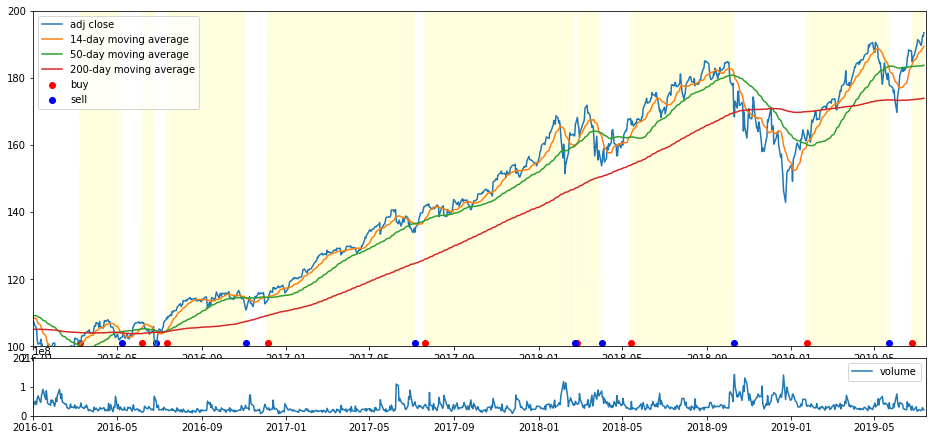

In [32]:
#plot (including bullish vs bearish regime)

plt.figure(figsize=(16,10))
ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1) 
ax2 = plt.subplot2grid((8,1), (5,0), rowspan=1, colspan=1, sharex=ax1) 
ax1.plot(df.index, df['Adj Close'], label='adj close')
ax1.plot(df.index, df['14d'], label='14-day moving average')
ax1.plot(df.index, df['50d'], label='50-day moving average')
ax1.plot(df.index, df['200d'], label='200-day moving average')


# lightyellow --> bullish regime
ax1.fill_between(df.index, df['Regime']*100+100, color='lightyellow')
ax1.scatter(df[df['Signal']==1].index, df[df['Signal']==1]['Signal']*1+100, color='red', label='buy')
ax1.scatter(df[df['Signal']==-1].index, df[df['Signal']==-1]['Signal']*(-1)+100, color='blue', label='sell')

ax2.plot(df.index, df['Volume'], label='volume')


# set xlim
start_date1 = dt.datetime(2016, 1, 1)
end_date = dt.datetime.now()
ax1.set_xlim([start_date1, end_date ])
ax2.set_xlim([start_date1, end_date ])
ax1.set_ylim([100, 200])
ax2.set_ylim([0, 0.2e9])


ax1.legend();ax2.legend()
plt.show()